In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import random as random
import matplotlib.pyplot as plt

/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [79]:
# Construct import data function, tensor variable initializers.

PATH_TRAIN = './input/train.csv'
PATH_TEST = './input/test.csv'

def import_data(path_train, path_test):
    '''
    Import train data and test data from path.
    '''
    data_train = pd.read_csv(path_train).as_matrix()
    data_test = pd.read_csv(path_test).as_matrix()

    np.random.shuffle(data_train)
    
    return data_train[:, 1:], data_train[:, 0:1].reshape(data_train.shape[0], 1),\
            data_test

def kernel_initializer(shape):
    '''
    Initial kernel in convolution layer or weight in full connection layer.
    '''
    initial = tf.truncated_normal(shape=shape, stddev=0.1, dtype="float32")
    return tf.Variable(initial_value=initial)

def bias_initializer(shape):
    initial = tf.constant(shape=shape, value=0, dtype="float32")
    return tf.Variable(initial_value=initial)
    

In [80]:
# Import data.
data_train, label_train, data_test = import_data(PATH_TRAIN, PATH_TEST)

# Divide to validation data
# 42000 = 4200 + 37800
data_valid = data_train[0:4200, :]
label_valid = label_train[0:4200, :].reshape([4200, 1])

data_train = data_train[4200:, :]
label_train = label_train[4200:, :].reshape([label_train.shape[0]-4200, 1])

In [4]:
## Prepare for the trainable variables.

# Convolution layer C1 trainable variables.
kernel_c1 = kernel_initializer((5, 5, 1, 6))
bias_c1 = bias_initializer((6, ))

# Subsample layer S2 trainable variables.
kernel_s2 = kernel_initializer((6,))
bias_s2 = bias_initializer((6,))

# Convolution layer C3 trainable variables.
kernel_c3 = kernel_initializer((5, 5, 6, 16))
bias_c3 = bias_initializer((16, ))

# Subsample layer S4 trainable variables.
kernel_s4 = kernel_initializer((16,))
bias_s4 = bias_initializer((16,))

# Convolution layer C5 trainable variables.
kernel_c5 = kernel_initializer((4, 4, 16, 120))
bias_c5 = bias_initializer((120,))

# Full connection layer F6 trainable variables.
kernel_f6 = kernel_initializer((120, 84))
bias_f6 = bias_initializer((84,))

# Full connection layer output trainable variables.
kernel_f7 = kernel_initializer((84, 10))
bias_f7 = bias_initializer((10,))



In [5]:
## Forward propapation (connect the graph).

# Make placeholder.
X = tf.placeholder(shape=[None, 28, 28, 1], dtype="float32")
Y = tf.placeholder(shape=[1, None], dtype="float32")

# Convolution layer 1, kernel = 5x5x6, output batchx24x24x6（add relu layer）
# X1 = tf.nn.conv2d(X, kernel_c1, strides=[1, 1, 1, 1], padding="VALID")+bias_c1
conv1 = tf.nn.conv2d(X, kernel_c1, strides=[1, 1, 1, 1], padding="VALID")
X1 = tf.nn.relu(tf.nn.bias_add(conv1, bias_c1))

# Subsample layer 2, output batchx12x12x6
# X2 = tf.nn.avg_pool(X1, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")*kernel_s2+bias_s2
X2 = tf.nn.max_pool(X1, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# Convolution layer 3, kernel = 5x5x6x16, output batchx8x8x16
# X3 = tf.nn.conv2d(X2, kernel_c3, strides=[1, 1, 1, 1], padding="VALID")+bias_c3
conv3 = tf.nn.conv2d(X2, kernel_c3, strides=[1, 1, 1, 1], padding="VALID")
X3 = tf.nn.relu(tf.nn.bias_add(conv3, bias_c3))

# Subsample layer 4, output batchx4x4x16
#X4 = tf.nn.avg_pool(X3, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")*kernel_s4+bias_s4
X4 = tf.nn.max_pool(X3, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# Convolution layer 5, kernel = 4x4x16x120, output batchx1x1x120
conv5 = tf.nn.conv2d(X4, kernel_c5, strides=[1, 1, 1, 1], padding="VALID")
X5 = tf.nn.relu(tf.nn.bias_add(conv5, bias_c5))

X5_ = tf.reshape(X5, [-1, 120])

# Full Connection Layer 6, kernel = 1x1x120x84, output batchx1x1x84
X6 = tf.nn.relu(tf.matmul(X5_, kernel_f6)+bias_f6)

# Full Connection Layer 7, kernel = 84x10, output batchx1x1x10
X7 = tf.matmul(X6, kernel_f7)+bias_f7

batch = 420

# Compute loss and make optimite
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(tf.to_int64(Y), [batch, ]),\
                                             logits=X7)
# X7_ = tf.reduce_max(X7, axis=-1)
# loss = tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = X7_)
optimite = tf.train.GradientDescentOptimizer(learning_rate=0.00002).minimize(loss)

# Compute accuracy
Y_ = tf.arg_max(X7, dimension=-1)
accuracy = 1-tf.count_nonzero(tf.to_int64(tf.squeeze(Y))-tf.squeeze(Y_))/batch


Instructions for updating:
Use `argmax` instead


In [6]:
# Train
epoch = 200
ep_train = round(data_train.shape[0]/batch)
ep_valid = round(data_valid.shape[0]/batch)

aclist_train = [];
aclist_valid = [];
loss_train = [];
loss_valid = [];

sess = tf.Session()
g_init = tf.global_variables_initializer()
sess.run(g_init)

for train_epoch in range(epoch):
    # Training Set.
    acc_train = 0
    loss_t = 0
    for i in range(ep_train):
        _, acc, lo = sess.run([optimite, accuracy, loss], \
                                 feed_dict={X: data_train[i*batch:(i+1)*batch, :].reshape([batch, 28, 28, 1]),\
                                            Y: label_train[i*batch:(i+1)*batch].reshape([1, batch])})
        acc_train += acc
        loss_t += lo
    
    # Validation Set.
    acc_valid = 0
    loss_v = 0
    for i in range(ep_valid):
        acc, lo = sess.run([accuracy, loss], feed_dict={X: data_valid[i*batch:(i+1)*batch, :].reshape([batch, 28, 28, 1]),\
                                            Y: label_valid[i*batch:(i+1)*batch].reshape([1, batch])})
        acc_valid += acc
        loss_v += lo
        
    
    aclist_train.append(acc_train/ep_train)
    aclist_valid.append(acc_valid/ep_valid)
    loss_train.append(loss_t/ep_train)
    loss_valid.append(loss_v/ep_valid)
    
    print("[Epoch %d]: Train accuracy %f,  Validation data accuracy %f"%(train_epoch, acc_train/ep_train, acc_valid/ep_valid))

[Epoch 0]: Train accuracy 0.167328,  Validation data accuracy 0.203333
[Epoch 1]: Train accuracy 0.490291,  Validation data accuracy 0.802619
[Epoch 2]: Train accuracy 0.846508,  Validation data accuracy 0.888095
[Epoch 3]: Train accuracy 0.888677,  Validation data accuracy 0.900000
[Epoch 4]: Train accuracy 0.905423,  Validation data accuracy 0.906667
[Epoch 5]: Train accuracy 0.915423,  Validation data accuracy 0.917619
[Epoch 6]: Train accuracy 0.923095,  Validation data accuracy 0.927381
[Epoch 7]: Train accuracy 0.928651,  Validation data accuracy 0.934048
[Epoch 8]: Train accuracy 0.933677,  Validation data accuracy 0.935714
[Epoch 9]: Train accuracy 0.937857,  Validation data accuracy 0.942619
[Epoch 10]: Train accuracy 0.941746,  Validation data accuracy 0.946667
[Epoch 11]: Train accuracy 0.945079,  Validation data accuracy 0.948810
[Epoch 12]: Train accuracy 0.948492,  Validation data accuracy 0.948810
[Epoch 13]: Train accuracy 0.951164,  Validation data accuracy 0.950714
[E

[Epoch 114]: Train accuracy 0.997196,  Validation data accuracy 0.991190
[Epoch 115]: Train accuracy 0.997646,  Validation data accuracy 0.992619
[Epoch 116]: Train accuracy 0.998095,  Validation data accuracy 0.992619
[Epoch 117]: Train accuracy 0.998280,  Validation data accuracy 0.993095
[Epoch 118]: Train accuracy 0.998492,  Validation data accuracy 0.993810
[Epoch 119]: Train accuracy 0.998545,  Validation data accuracy 0.993810
[Epoch 120]: Train accuracy 0.998915,  Validation data accuracy 0.994524
[Epoch 121]: Train accuracy 0.999048,  Validation data accuracy 0.995238
[Epoch 122]: Train accuracy 0.999180,  Validation data accuracy 0.995714
[Epoch 123]: Train accuracy 0.999312,  Validation data accuracy 0.996667
[Epoch 124]: Train accuracy 0.999365,  Validation data accuracy 0.997619
[Epoch 125]: Train accuracy 0.999524,  Validation data accuracy 0.996667
[Epoch 126]: Train accuracy 0.999603,  Validation data accuracy 0.997619
[Epoch 127]: Train accuracy 0.999603,  Validation d

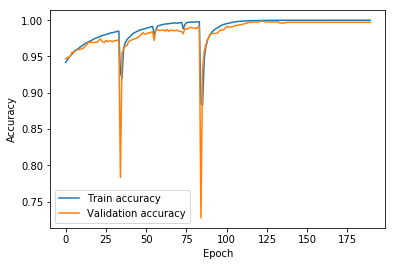

In [7]:
# Print accuracy
plt.plot(aclist_train[10:], label="Train accuracy")
plt.plot(aclist_valid[10:], label="Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [81]:
# Predict test data with trained model.
predict = sess.run(Y_, feed_dict={X: data_test.reshape([data_test.shape[0], 28, 28, 1])})
predict = predict.reshape(predict.shape[0], 1)
image_id = np.arange(1, len(predict) + 1, 1)
image_id = image_id.reshape(len(predict), 1)
np.savetxt('3-layer_L2_NN.csv', np.c_[image_id, predict], delimiter=',', header='ImageId,Label', comments='', fmt='%d')

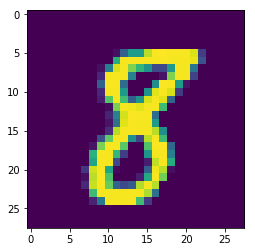

[8]


In [86]:
i = 8880
plt.imshow(data_test[i, :].reshape([28, 28]))
plt.show()
print(predict[i])

array([2])

In [ ]:
sess.close()